# Explicabilidade de modelos: uma análise de grupos salariais

Nome: Isadora Alves de Salles <br>
Matrícula: _2017014553_

### Introdução:
Devido a um grande espectro de fatores históricos e sociais, é sabido que fatores como gênero e grau de escolaridade afetam diretamente o patamar salarial das pessoas. O objetivo deste trabalho portanto, é utilizar o dataset "Adult Census Income" para criar um modelo capaz de prever se o salário anual de uma determinada pessoa é acima ou abaixo de 50 mil dólares. Uma vez treinado o modelo, posteriormente utilizando metodologias de explicabilidade para evidenciar mazelas sociais através da determinação da importância que cada feature teve para a decisão do modelo.

### Metogologia:

Para elaborar o modelo, utilizando a área abaixo da curva característica de operação do receptor como métrica de performance, foi feita uma sondagem de vários modelos diferentes: Decision Tree, Random Forest, Extreme Gradient Boosting e Light Gradient Boosting Machine. Tendo estabelecido o modelo de regressão logística como baseline de comparação e analisando os modelos tanto por suas acurácias quanto AUC, conclui-se que o mais performático foi o LightGBM. Para obter explicações sobre as decisões do modelo para cada indivíduo no dataset e então obter um certo grau de interpratabilidade dos resultados obtidos, foram efetivadas as seguintes metodologias:

- Shapley Additive Explanations (SHAP), para obter a importância de cada uma das features na decisão do modelo.

- Visualização t-SNE utilizando os valores SHAP (importância das features) para cada um dos indivíduos, aliada da probabilidade de cada um deles para estabelecer uma correlação entre importância das features e a classificação binária obtida e as probabilidades da predição.


## Imports necessários

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import seaborn as sns

# sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import sklearn.preprocessing as preprocessing

# SHAP
import shap

# t-SNE
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore") #ignore deprecated warnings

# print the JS visualization code to the notebook
shap.initjs()

## Variáveis

In [2]:
# Caminho para o dataset
INPUT_FILEPATH = "adult.csv"

# Nome da coluna do label 
TARGET = "income"

# Número de folds no K-fold cross-validation
N_FOLDS = 10

## Resumo dos Dados


In [3]:
# Leitura do dataset para um DataFrame do Pandas
# (neste caso ele usa o separador default que eh a virgula)
df = pd.read_csv(INPUT_FILEPATH)

# Remove colunas que nao serao usadas
#df = df.drop(["Date", "Location", "RISK_MM"], axis=1)

# Imprime algumas informacoes basicas sobre os dados
print("Numero de linhas: {}".format(df.shape[0]))
print("Numero de colunas: {}".format(df.shape[1]))

# Para tratar dados faltantes
df = df.replace('?',np.nan)
print("Dados faltando: {}".format(df.isna().sum().sum()))

print("\nAmostra:")
with pd.option_context("max_columns", 12): # Limita o numero de cols mostradas
    display(df.head())
    


Numero de linhas: 48842
Numero de colunas: 15
Dados faltando: 6465

Amostra:


,age,workclass,fnlwgt,education,educational-num,marital-status,...,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,...,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,...,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,...,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,...,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,...,Female,0,0,30,United-States,<=50K


### Dados Faltantes


Temos poucos dados faltando, nao é necessário excluir nenhuma coluna, apenas algumas linhas.

In [4]:
df.isnull().sum().to_frame("Dados faltando").join(
    (df.isnull().sum().to_frame("%")*100/len(df)).round(2))

,Dados faltando,%
age,0,0.00
workclass,2799,5.73
fnlwgt,0,0.00
education,0,0.00
educational-num,0,0.00
marital-status,0,0.00
occupation,2809,5.75
relationship,0,0.00
race,0,0.00
gender,0,0.00


Eliminar linhas com dados faltando.

In [5]:
n_before = df.shape[0]
df = df.dropna(axis=0, how="any")
print("\nLinhas removidas: {}".format(n_before - df.shape[0]))

# Certifica que nao ha mais dados faltando
assert df.isnull().sum().sum() == 0


Linhas removidas: 3620


## Análise exploratória

In [6]:
# Colunas com dados categoricos
cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]

# Colunas com dados numericos (reais)
real_cols = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]

### Features Categóricas

In [7]:
for c in cat_cols:
    display((df[c].value_counts().sort_index()/len(df)*100).round(2).to_frame(c +" (%)").T)

,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
workclass (%),3.11,6.86,73.65,3.64,8.39,4.3,0.05


,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
education (%),2.7,3.58,1.28,0.49,0.99,1.82,1.49,3.33,4.33,16.74,1.2,32.69,5.56,0.16,1.74,21.89


,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
marital-status (%),13.92,0.07,46.56,1.22,32.28,3.12,2.82


,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
occupation (%),12.25,0.03,13.31,13.23,3.27,4.52,6.57,10.63,0.51,13.29,2.16,11.96,3.14,5.12


,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
relationship (%),41.28,25.88,2.98,14.65,10.59,4.62


,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
race (%),0.96,2.88,9.35,0.78,86.03


,Female,Male
gender (%),32.5,67.5


,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
native-country (%),0.06,0.36,0.25,0.18,0.29,0.21,0.1,0.33,0.26,0.08,...,0.14,0.39,0.04,0.22,0.12,0.06,0.06,91.31,0.18,0.05


Podemos deletar a coluna "education" pois representa as mesmas informações que "educational-num".

In [8]:
df[["education", "educational-num"]].head(15)

,education,educational-num
0,11th,7
1,HS-grad,9
2,Assoc-acdm,12
3,Some-college,10
5,10th,6
7,Prof-school,15
8,Some-college,10
9,7th-8th,4
10,HS-grad,9
11,Bachelors,13


In [9]:
del df['education']

### Features numéricas

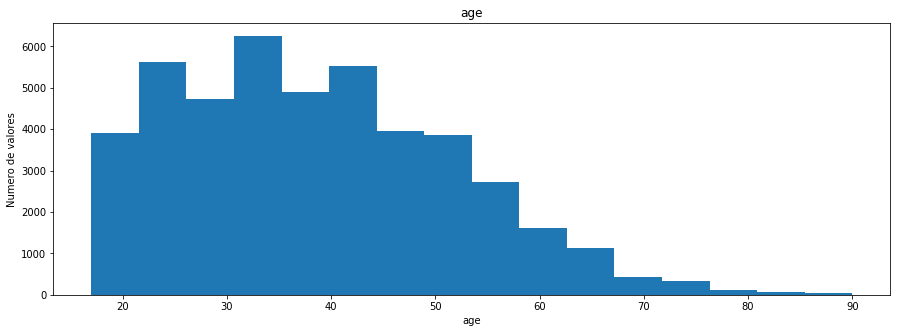

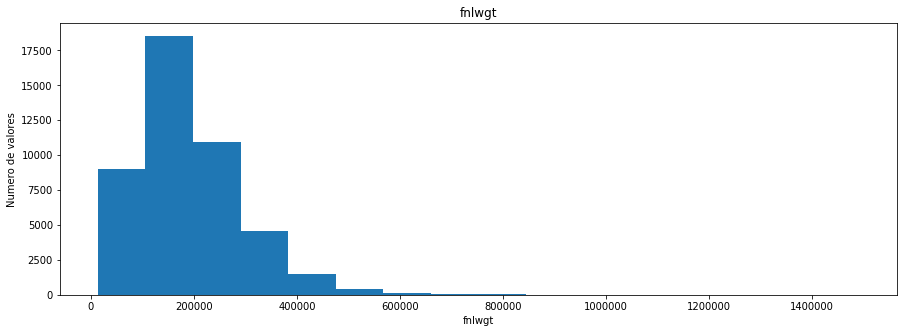

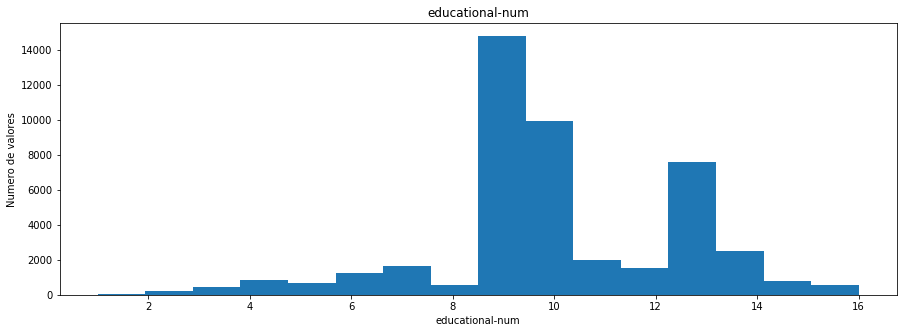

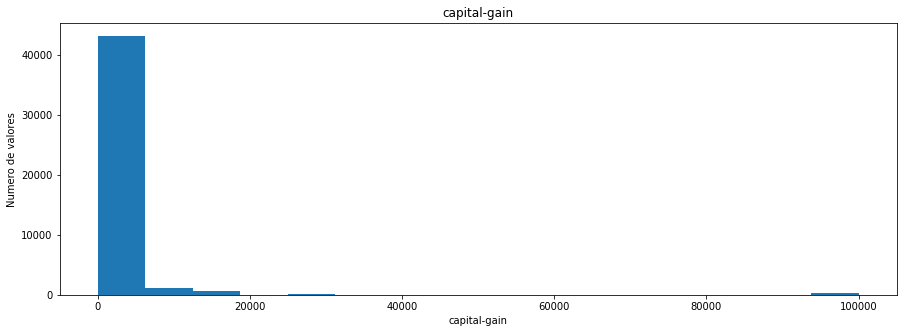

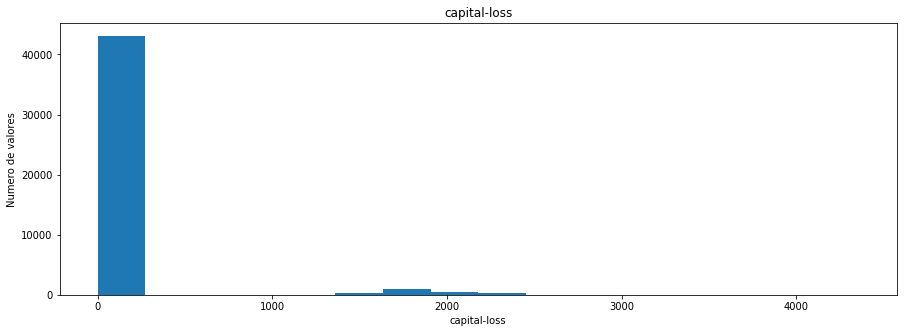

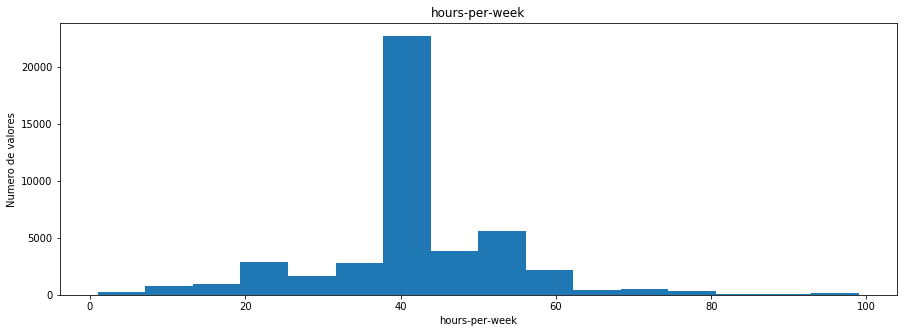

In [10]:
for c in real_cols:
    plt.figure(figsize=(15, 5))
    plt.hist(df[c], bins=16)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Numero de valores")
    plt.show()

Devemos deletar a feature "fnlwgt" pois a mesma já é um indicativo da target.

In [11]:
del df['fnlwgt']

### Target

Percebemos que existem mais dados de pessoas que recebem menos que 50K (75% dos dados).

In [12]:
display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

,<=50K,>50K
income (%),75.22,24.78


## Preprocessamento

### Dados categóricos

Codifica os dados categóricos para números. Foi escolhido esse tipo de encoder ao invés do one-hot encoding pelo fato de possuirmos muitas classes para cada uma das features categóricas. Se binarizassemos todos os atributos teríamos muitas features ao final do processo. Além disso, para realizar a explicabilidade do modelo é mais interessante esse tipo de encoder.

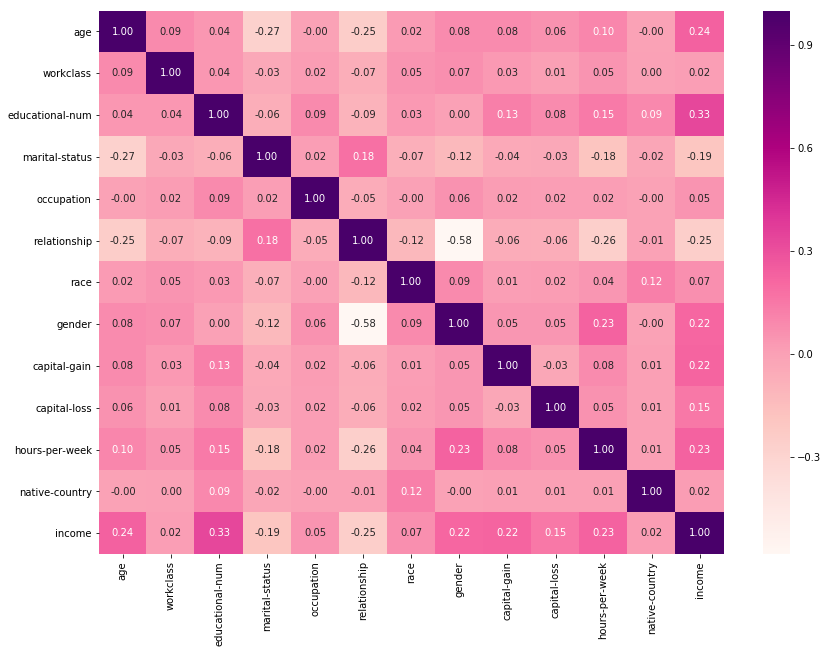

In [13]:
def number_encode_features(df):
    result = df.copy()
    r = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            r[column] = encoders[column].fit_transform(result[column].astype(str))
    return r, encoders

# Calcula a correlacao e plota a matriz
encoded_data, _ = number_encode_features(df)
plt.figure(figsize=(14,10))
sns.heatmap(encoded_data.corr(),annot=True,fmt='.2f', cmap=plt.cm.RdPu)
plt.show()

### Target

Com a codificação acima foram criados de labels binários para a target, sendo 0 para os falso positivos (<=50K) e 1 para os confirmados (>50K).

In [14]:
display(encoded_data[[TARGET]].sample(10))

,income
1101,0
22513,0
19104,0
36199,0
22777,0
2619,1
5409,0
15204,0
34433,0
46360,1


### Representação dos dados codificados

Como se distribuem os dados.

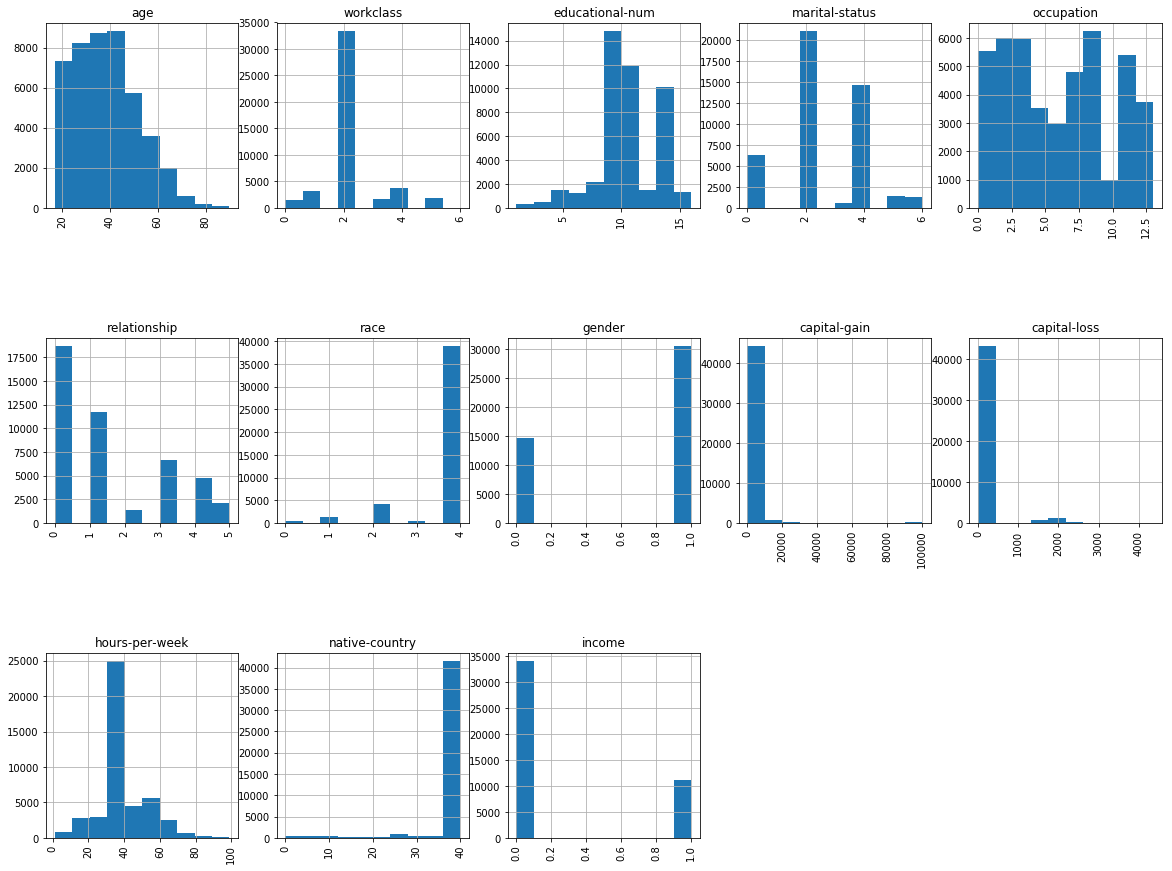

In [15]:
encoded_data, encoders = number_encode_features(df)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Listar features

In [16]:
features = list(encoded_data.columns)
features.remove(TARGET)

print("Target: {}".format(TARGET))
print("Features:")
print("\n".join(["  " + x for x in features]))

Target: income
Features:
  age
  workclass
  educational-num
  marital-status
  occupation
  relationship
  race
  gender
  capital-gain
  capital-loss
  hours-per-week
  native-country


### Separação de treino, validação e teste

Primeiramente, dividimos os dados em treino e teste, sendo 33% dos dados usados para teste. Sobre os dados de treino faz-se cross-validation. Então um objeto com os parametros do KFold é criado, e asseguramos que as k particoes tenham a mesma proporção de dados das duas classes de y. Os valores são usados para validação apenas uma vez, ou seja, em cada k fold de validação teremos elementos distindos. 



In [17]:
X = encoded_data[features].values 
y = encoded_data[TARGET].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

kf = KFold(n_splits = N_FOLDS, random_state = 1, shuffle = True)

# Classificação 

Nesta etapa há a definição de cada modelo, seguida do experimento do mesmo variando os hiperparâmetros necessários. Para cada experimento realizado foi explicado o objetivo do experimento e o significado do hiperparâmentro variado.

### Definição das variáveis globais e de funções a serem chamadas nos experimentos dos modelos

In [18]:
bestModelsTestAcc = []
bestModelsRecall = []
bestModelsPrecision = []
bestModelsF1Score = []
bestModelsPred = []
bestModelsProba = []
models = ["Regressao Logistica", "Decision tree", "Random Forest", "XGBoost", "LightGBM"]

A função abaixo foi utilizada para armazenar as características do melhor modelo encontrado em cada experimento. O melhor modelo é dado pela melhor acurácia de validação, dado que não tenha ocorrido overfitting. Salvamos então a sua acurácia de teste, a propabilidade de predição da classe 1, a predição e as métricas de precisão, revocação e F1. 

In [19]:
def bestModel(testAcc_model, recall_model, f1_score_model, precision_model, proba, predictions):
    bestModelsTestAcc.append(testAcc_model)
    bestModelsPrecision.append(precision_model)
    bestModelsRecall.append(recall_model)
    bestModelsF1Score.append(f1_score_model)
    bestModelsProba.append(proba)
    bestModelsPred.append(predictions)

A função abaixo é utilizada para plotar a curva de acurácia de treino e validação pela variação do hiperparâmetro:

In [20]:
def plot_curva(x, y1, y2, x_label, y_label):
    plt.figure(figsize=(8, 5))
    plt.cm.RdPu
    plt.plot(x, y1, label= "Training", c= 'blue' )
    plt.plot(x, y2, label= "Validation", c='deeppink')
    # distinção para plotar gráfico da decision tree no ponto em que temos altura ilimitada
    if x_label == "max_depth":
        trainAcc, valAcc = decision_tree(None) 
        plt.plot([20], [trainAcc], 'bo',  ms=15, label = 'No depth limit training(y-axis only)')
        plt.plot([20], [valAcc], 'ro', ms=15, label = 'No depth limit 5-fold validation(y-axis only)')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

## Logistic Regression

In [21]:
#baseline
def logistic_regression():
    train_score = []
    val_score = []
    
    # separa partições para validação e o resto para treino em KFolds
    for train, val in kf.split(X_train, y_train): 
            
        classifier = LogisticRegression(solver='newton-cg') # cria o objeto do modelo
        classifier = classifier.fit(X_train[train], y_train[train])  # treina o modelo com os dados do fold

        # armazena a acurácia de treino e validação para cada fold
        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

O Logistic Regression será o baseline para o trabalho.

Para o Logistic Regression como temos apenas um experimento para servir de baseline, sem a variação de nenhum hiperparâmetro, nas posição 0 dos nossos vetores que armazenam os melhores resultados de cada modelo teremos o resultado de acurácia de teste abaixo, assim como as métricas.

In [22]:
trainAcc, valAcc = logistic_regression()

model = LogisticRegression(solver='newton-cg')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.821


## Decision Tree

In [23]:
def decision_tree(H):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X_train, y_train):
           
        classifier = DecisionTreeClassifier(max_depth= H,min_samples_leaf=100,random_state=10)
        classifier = classifier.fit(X_train[train], y_train[train])

        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

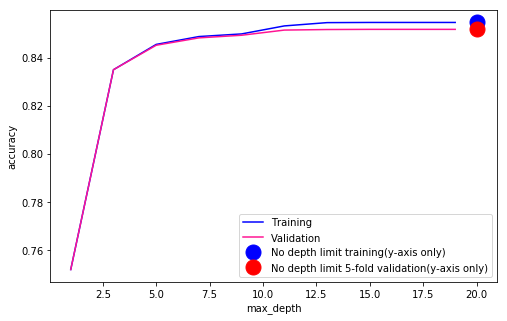

In [24]:
acc_modelTrain = []
acc_modelVal = []
max_depth = list(range(1,21,2)) #Valores usados para variar a altura da árvore 
for i in max_depth:
    trainAcc, valAcc = decision_tree(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(max_depth, acc_modelTrain, acc_modelVal, "max_depth", "accuracy")

Para treinar este modelo a altura/profundidade máxima da árvore de decisão foi variada de 1 a 21 (2 a 2), além de contar com o uso de "None" que implica em permitir altura máxima ilimitada. O hiperparâmentro variado ("max_depth") limita a profundidade da árvore, uma vez atingido o limite, splits não serão mais feitos. Se a altura é None, os nodes são expandidos até todas as folhas puras ou até que todas as folhas tenham menos que min_samples_split amostras.

Como pode ser observado no gráfico, até a altura limite igual a 12 temos um ganho significativo na acurácia de validação. Após esse ponto ainda existe um aumento na acurácia de validação, porém de forma pouco significativa, sendo assim preferimos um modelo mais simples. Podemos ver que não ocorreu overfitting, mas como a partir de um ponto a acurácia parou de crescer significativamente, escolhemos esse ponto para ser o melhor modelo, que no caso é a profundidade limite de 12.

Abaixo as métricas para o melhor modelo serão salvas e há o print da acurácia no conunto de teste:

In [25]:
model = DecisionTreeClassifier(max_depth= 12,min_samples_leaf=100,random_state=10)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.855


## Random Forest

In [26]:
def random_forest(N):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X, y):

        classifier = ensemble.RandomForestClassifier(n_estimators=N, max_features=5, min_samples_leaf=50, 
                                                     random_state=24)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)

    return trainAcc, valAcc

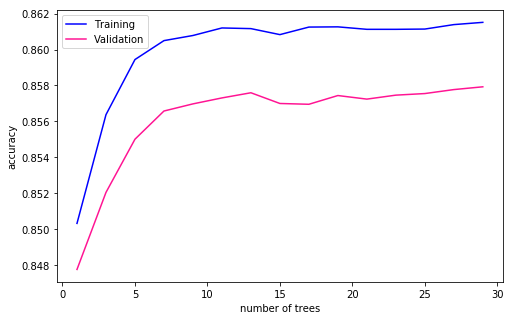

In [27]:
acc_modelTrain = []
acc_modelVal = []
n_trees = list(range(1,31,2)) #Valores do número de árvores a ser variado
for i in n_trees:
    trainAcc, valAcc = random_forest(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_trees, acc_modelTrain, acc_modelVal, "number of trees", "accuracy")

Para o Random Forest vários modelos foram treinados com o número de árvores variando entre 1 e 31 (2 a 2). Neste modelo é feito um ensemble de várias árvores de decisão, assim esse hiperparâmetro irá limitar o número de árvores que serão geradas durante o treino. Este tipo de classificador tenta atacar os erros que ocorrem devido a variância, utilizando a ideia de bagging o dado não será memorizado pois estamos sempre trabalhando com uma amostra do dado. Isso produz um modelo mais robusto a variãncias nos dados de teste, ou seja mais robusto a overfitting. No gráfico acima aparentemente há uma distância grande entre as curvas, mas isso é devido a escala do gráfico e ao fato de que a acurácia inicial do Random Forest já é alta.

Como pode ser observado no gráfico o melhor hiperparâmetro para o modelo, neste experimento, é o de 13 árvores, pois após este número existe um afastamento significativo entre as duas curvas.

Na célula abaixo as métricas do melhor modelo são salvas e há o print da acurácia no conjunto de teste para este modelo:

In [28]:
model = ensemble.RandomForestClassifier(max_depth= 13, max_features=5, min_samples_leaf=50, 
                                                     random_state=24)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.857


## Extreme Gradient Boosting

In [29]:
def xgb(N):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X_train, y_train):
            
        classifier = XGBClassifier(n_estimators=N, importance_type='gain')
        classifier = classifier.fit(X_train[train], y_train[train])

        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

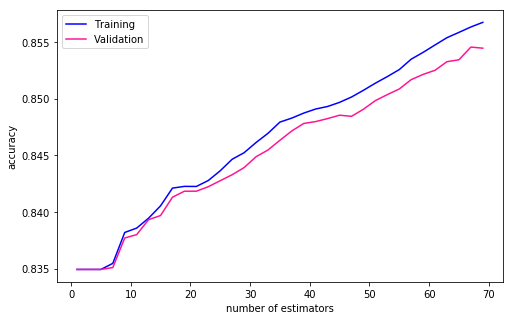

In [30]:
acc_modelTrain = []
acc_modelVal = []
n_iter = list(range(1,71,2)) #Valores do número de estimadores a ser variado
for i in n_iter:
    trainAcc, valAcc = xgb(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_iter, acc_modelTrain, acc_modelVal, "number of estimators", "accuracy")

O extreme gradient boosting é uma implementação específica do gradient boosting usando aproximações mais acuradas para encontrar o melhor modelo. 

Para o extreme gradient boosting o hiperparâmetro variado foi o n_estimators, sendo variado de 1 a 71 (2 a 2). Esse hiperparâmetro controla o número de etapas que serão efetivadas no modelo. Este tipo de classificador é construido a partir da junção de modelos mais simples, atacando os erros devido ao viés, pois a cada iteração mudamos o viés do modelo para atacar os erros dos modelos anteriores. Assim, construimos um classificador mais robusto ao overfitting justamente pelo uso de classificadores fracos, isso pode ser observado no gráfico acima, pois tem-se uma proximidade muito grande entre as duas curvas. A performance desse modelo tende a melhorar cada vez mais devido ao fato de que ele demora mais que outros para overfitar.

Devido a forma que é configurado, a complexidade do modelo não aumenta, assim devemos selecionar o melhor modelo dado a melhor acurácia sem nos importar com a complexidade. Assim, temos que para o extreme gradient boosting o melhor modelo será o que foi testado com maior número de estimadores. Isso pode ser observado no gráfico acima, pois ambas as curvas de acurácia tendem a subir, e em nenhum momento observamos o aumento da acurácia de treino em conjunto com a diminuição da acurácia de validação (o que configuraria um overfitting), assim o melhor modelo será o com 71 estimadores, que é o maior valor testado.

Na célula abaixo as métricas do melhor modelo são salvas e há o print da acurácia no conjunto de teste para este modelo:

In [31]:
model = XGBClassifier(n_estimators=71, importance_type='gain')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.859


## Light Gradient Boosting Machine

In [32]:
def light_gboost(N):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X_train, y_train):
            
        classifier = LGBMClassifier(n_estimators=N)
        classifier = classifier.fit(X_train[train], y_train[train])

        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

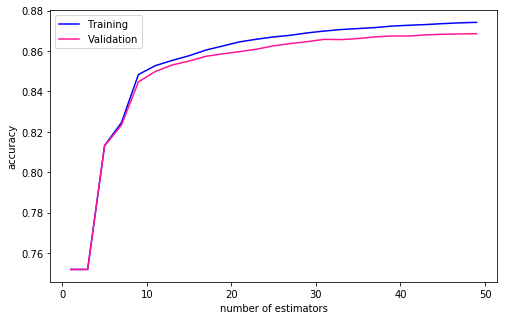

In [33]:
acc_modelTrain = []
acc_modelVal = []
n_iter = list(range(1,51,2)) #Valores do número de estimadores a ser variado
for i in n_iter:
    trainAcc, valAcc = light_gboost(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_iter, acc_modelTrain, acc_modelVal, "number of estimators", "accuracy")

LightGBM é uma implementação similar ao XGBoost, mencionado anteriormente, mas varia de maneiras específicas como no modo que as árvores são criadas.

Para o light gradient boosting machine o hiperparâmetro variado foi o n_estimators, sendo variado de 1 a 51 (2 a 2). Esse hiperparâmetro controla o número de etapas que serão efetivadas no modelo assim como dito no XGBoost.

A mesma análise feita para a escolha do melhor hiperparâmetro do extreme gradient boosting cabe aqui, ou seja, devido a forma que o modelo é configurado, a complexidade dele não aumenta, assim devemos selecionar o melhor modelo dado a melhor acurácia sem nos importar com a complexidade. Assim, temos que para o light gradient boosting machine o melhor modelo será o que foi testado com maior número de estimadores. Isso pode ser observado no gráfico acima, pois ambas as curvas de acurácia tendem a subir, e em nenhum momento observamos o aumento da acurácia de treino em conjunto com a diminuição da acurácia de validação (o que configuraria um overfitting), assim o melhor modelo será o com 51 estimadores, que é o maior valor testado.

Na célula abaixo as métricas do melhor modelo são salvas e há o print da acurácia no conjunto de teste para este modelo:

In [34]:
model = LGBMClassifier(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.869


# Comparação entre os melhores modelos de cada classificador

Na tabela abaixo observamos que os melhores dos melhores modelos, que possuem uma acurácia de teste melhor, assim como maior precisão são o LightGBM e o XGBoost, que são modelos de ensemble learning possuindo tratamento especial para evitar overfitting. 

A F1 score pode ser interpretada como uma medida de confiabilidade da acurácia, uma vez que seu valor é alto sabemos que a acurácia obtida foi relevante. Sendo assim, o modelo com maior F1 score foi o LightGBM, e será o que iremos escolher para continuar as análises. 

#### Resumo para cada modelo:

_Logistic Regression:_ Por ser um modelo mais simples sua precisão tende a ser mais baixa que a dos outros, e devido a simplicidade do problema em questão conseguimos encontrar bons resultados com este modelo. Porém, nosso baseline não obteve resultados melhores que nenhum dos outros modelos.

_Decision Tree:_ É um modelo mais robusto do que o Logistic Regression, mas ainda assim simples, por isso apresenta melhora na acurácia e precisão. 

_Random Forest:_ É mais robusto que o Decision Tree, sendo um aprimoramento do mesmo com o uso de várias decision trees. Dessa forma, quando comparados observamos que ambos têm uma acurácia relativamente próxima. 

_Extreme Gradient Boosting:_ É um modelo que generaliza mais que os demais modelos avaliados, pelo fato de se basear no boosting, dessa forma obteve o segundo menor recall e uma das melhores acurácias.

_Light Gradient Boosting Machine:_ É um modelo similar ao XGBoost, baseando-se também na técnica de boosting. É o model que possui a maior F1 score, que é a nossa medida de confiabilidade da acurácia, assim como maior acurácia. Será o modelo que vamos usar para explicabilidade.

In [35]:
raw_data = {'Acurácia de Teste' : bestModelsTestAcc, 'Recall': bestModelsRecall, 
            'F1 Score': bestModelsF1Score, 'Precision': bestModelsPrecision}
    
df_metrics = pd.DataFrame(raw_data, columns = ["Acurácia de Teste", "Recall", "F1 Score", 
                                       "Precision"], index = models)
display(df_metrics)

,Acurácia de Teste,Recall,F1 Score,Precision
Regressao Logistica,0.820692,0.458017,0.558270,0.714708
Decision tree,0.854664,0.598050,0.670615,0.763222
Random Forest,0.857210,0.598592,0.674706,0.772998
XGBoost,0.859086,0.568527,0.666243,0.804523
LightGBM,0.869405,0.651950,0.711814,0.783784


## Curva ROC

Para diferentes thresholds para a classe positiva, a curva ROC irá mostrar a taxa de verdadeiros positivos pela taxa de falsos positivos. E a área debaixo da curva encontrada expressa a capacidade do modelo de descriminar as classes.

Nas células abaixo temos a curva ROC para cada um dos melhores modelos, com a respectiva AUC:

In [36]:
bestModelsAUC = np.zeros(5)
def roc():
    i = 0
    for name, pred in zip(models, bestModelsProba):
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        auc = np.trapz(tpr, fpr)
        bestModelsAUC[i] = auc
        plt.figure(figsize=(7, 5))
        lw = 2
        plt.plot(fpr, tpr, color='royalblue',lw=2)
        plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC ('+name+')  -  AUC: '+str(auc))
        plt.show()
        i+=1

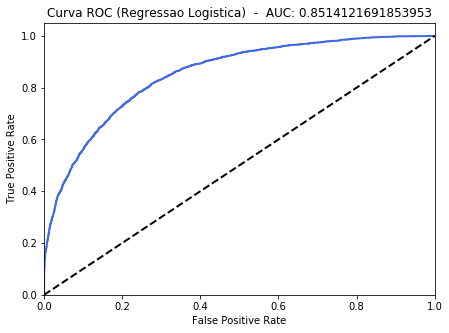

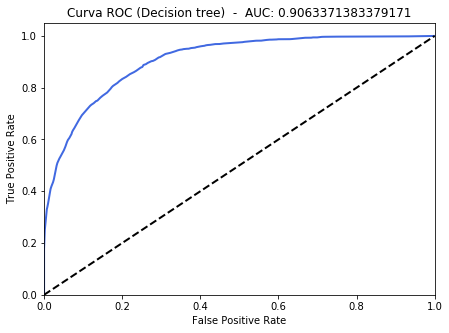

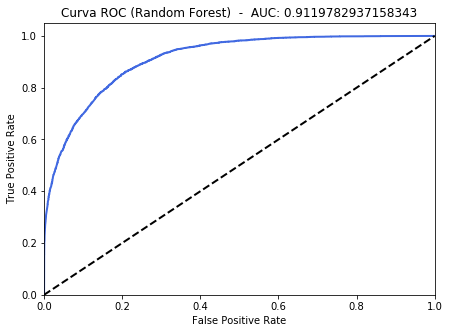

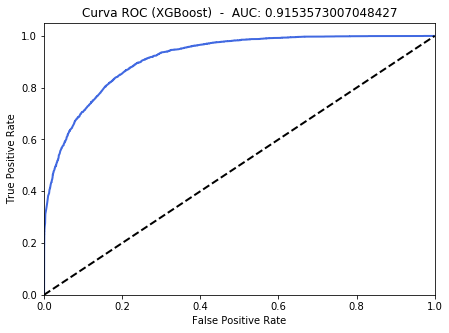

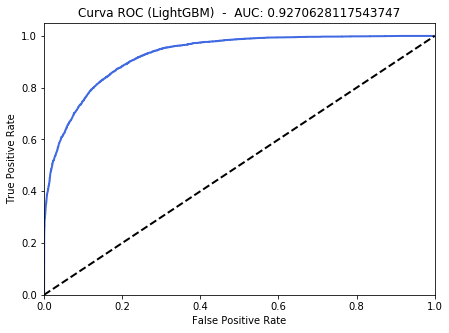

In [37]:
roc()

Nas curvas acima observamos, novamente, que o melhor modelo para este dado é realmente o Light Gradient Boosting Machine, devido ao fato de que é baseado em emsemble learning, e possui um tratamento especial para com os erros de viés e variância, já explicado anteriormente.

## AUC

Podemos ver que o maior valor de área sobre a curva é o do LightGBM, considerado o melhor modelo.

In [38]:
raw_data = {'Area Under ROC Curve' : bestModelsAUC}
    
df_auc = pd.DataFrame(raw_data, columns = ["Area Under ROC Curve"], index = models)
display(df_auc)

,Area Under ROC Curve
Regressao Logistica,0.851412
Decision tree,0.906337
Random Forest,0.911978
XGBoost,0.915357
LightGBM,0.927063


## Matrizes de Confusão

Nas matrizes de confusão todas as métricas já citadas anteriormente ficam mais visíveis, e podemos ver que o LightGBM é o modelo com menos numero de falsos negativos e falsos positivos.

In [39]:
# Matriz de Confusao
classes = ['0', '1']
def matriz_confusao():
    i = 0
    for name, pred in zip(models, bestModelsPred):
    
        cm = metrics.confusion_matrix(y_test, pred)

        fig, ax = plt.subplots(figsize=(7, 7))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title="Matriz de Confusão - "+name,
               ylabel="Real",
               xlabel="Predito")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], "d"),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max()/2. else "black")
        fig.tight_layout()
        plt.show()

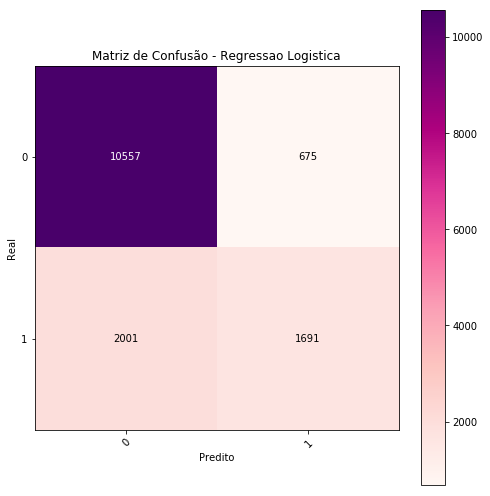

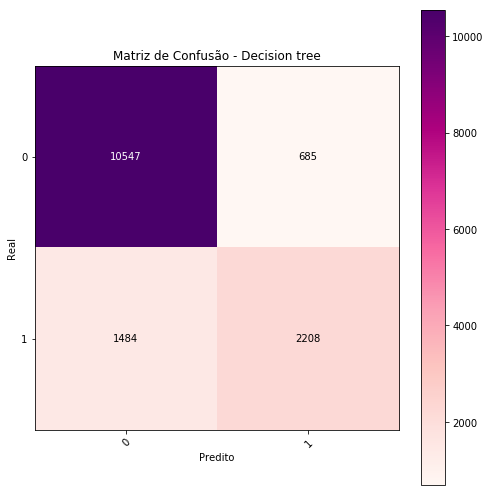

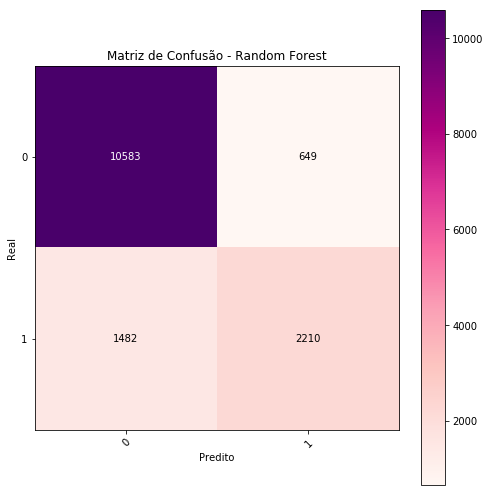

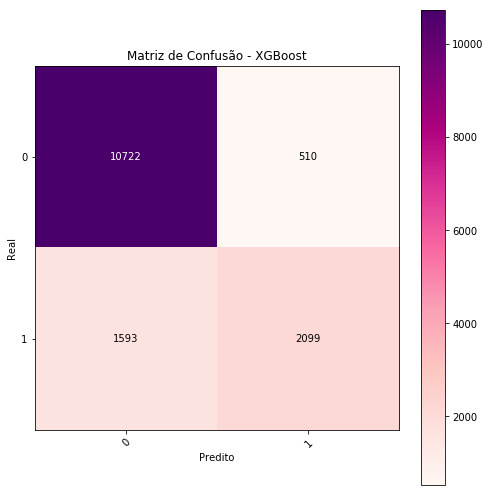

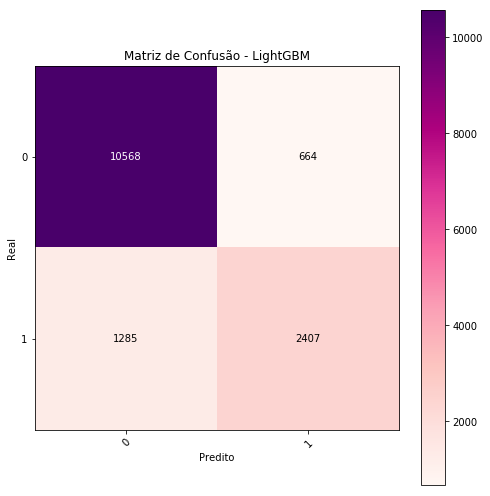

In [40]:
matriz_confusao()

# Explicabilidade das Predições do LightGBM

In [41]:
model = LGBMClassifier(n_estimators=51)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Usamos a implementação tree SHAP.

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(encoded_data[features])

#### Visualização de uma única predição
 
Aqui temos a força/relevância de cada feature para a predição.

In [43]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df[features].iloc[0,:])

## Importância Média

Para montar esse gráfico, foi pega a média dos valores do SHAP em relação ao dataset.

Aqui podemos ver a importância média de cada feature. Como era esperado, idade tem uma alta importância pois no dataset temos pessoas menores que 21 anos que se forem trabalhar irão com certeza receber menos devido ao fato de estarem estagiando, por exemplo. Estado civil também tem alta importância, e uma hipótese para que isso ocorra é que a mulher só passe a ver "necessidade" de trabalhar estando solteira ou divorciada. Outra feature muito relevante é o grau de escolaridade, o que também é esperado.

Perceba que o gênero e a raça tem importância inferior as outras features, o que é inesperado dado que temos muitos fatores históricos e sociais que comprovam o contrário. Vamos focar nessas features mais a frente.


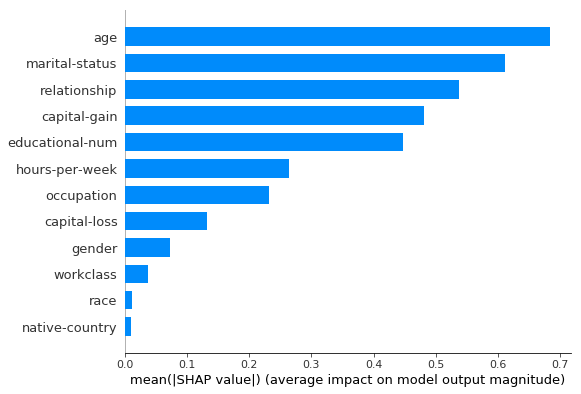

In [45]:
shap.summary_plot(shap_values, df[features], plot_type="bar")

## SHAP Summary

Temos um gráfico de dispersão de densidade do valor do SHAP para cada feature para identificar quanto cada feature têm de impacto na saída do modelo para pessoas no dataset inteiro. Features são ordenadas pela soma do valores SHAP em relação de todas as amostras. Em cada um dos lados dessa linha vertical teremos a representação de uma classe, para o lado esquerdo é ganhar menos que 50K para o direito, ganhar mais que 50K. Ou seja, os pontos a esquerda contribuem para a classificação 0, e os a direita para a classificação 1. Quanto mais longe do eixo central, maior a importância dessa features para a classificação do lado em que se encontra. O terceiro eixo é a cor, de azul a vermelho, e diz respeito ao valor das features de cada indivíduo. Se azul, valores baixo, caso contrário, valores altos.

É interessante notar que: as idades mais baixas têm maior importância para a classificação como classe 0. Assim como , os valores altos de capital-gain têm maior importância na classificação da classe 1. Ou até mesmo que valores mais altos de gênero (que no caso seria 1 e representa o gênero masculino) têm maior importância na classificação da classe1.


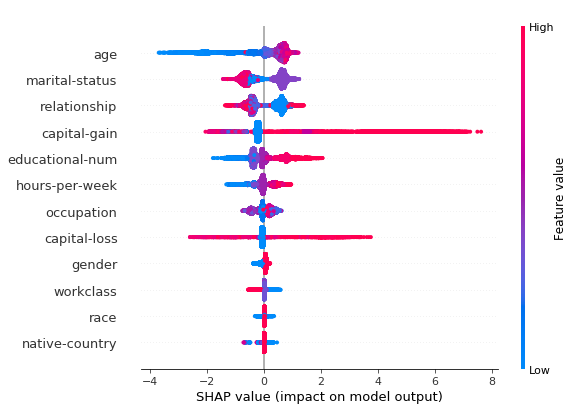

In [46]:
shap.summary_plot(shap_values, encoded_data[features])

## SHAP Dependence

SHAP dependence plots mostra o efeito de uma única features em relação ao restante do dataset. A dispersão vertical do valor do SHAP para uma feature é dada pela iteração dos efeitos, e outra feature é usada para colorir possíveis iterações. A ideia deste plot é a mesma do anterior, só que nesse caso estamos avaliando as possíveis categorias de uma feature, e usando outra feature para assumir a coloração de highlight. 

Abaixo foram plotados os gráficos para os atributos "workclass", "occupation", "race" e "gender". Como podemos ver workclass e occupation tem uma relação direta e esperada com a predição, se você ocupa um cargo superior irá receber um salário superior. Mas o que podemos dizer sobre raça e gênero?

1. No gráfico da raça, temos que todos os indivíduos negros (classe 2), pesam mais para a classificação da classe que ganha menos que 50K. Assim como os brancos são os que possuem menos "viés", não favorece nenhuma classificação apenas com a feature raça, e em conjunto com a coloração vemos que os valores de SHAP para as pessoas brancas estão uniformes em torno da reta que separa as duas classes. Para os negros, ser uma mulher pesa mais ainda para classificar como 0.

2. No gráfico do gênero, tendo 0 como mulher e 1 como homem, percebemos que há sim um certo peso para cada uma das classes, independente da idade que aqui foi retratada como nosso segundo eixo, ser mulher pesa para a classificação da classe 0 (<=50K). E ser uma mulher mais velha pesa ainda mais. Enquanto que ser homem pesa apenas para a classificação da classe 1.



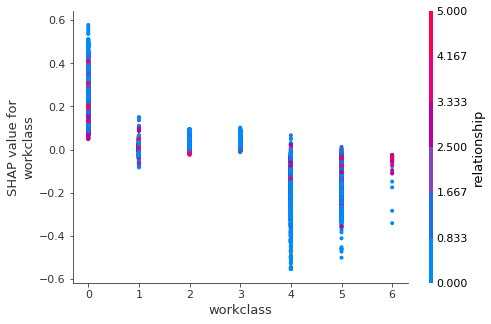

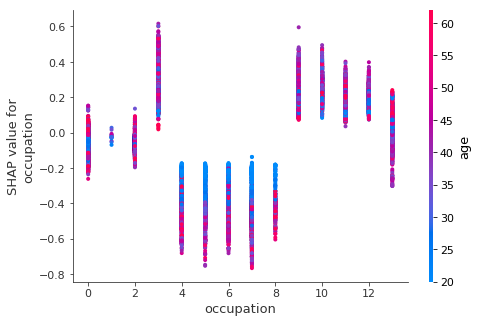

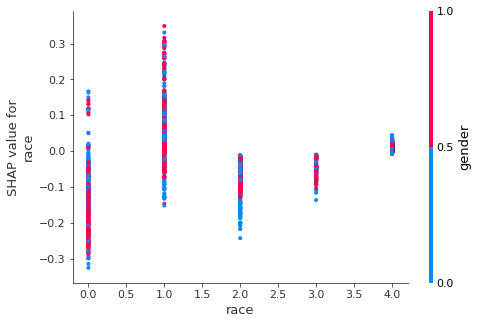

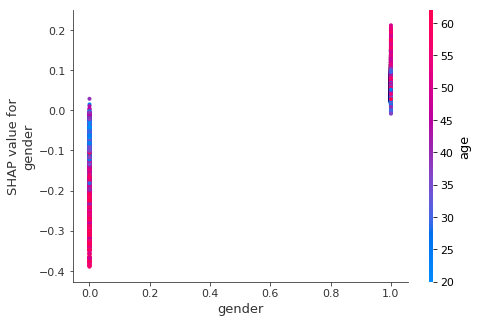

In [47]:
shap.dependence_plot('workclass', shap_values, encoded_data[features])
shap.dependence_plot('occupation', shap_values, encoded_data[features])
shap.dependence_plot('race', shap_values, encoded_data[features])
shap.dependence_plot('gender', shap_values, encoded_data[features])

## Visualização t-SNE 

Utilizando os valores SHAP (importância das features) para cada um dos indivíduos, aliada da probabilidade de cada um deles para estabelecer uma correlação entre importância das features e a classificação binária obtida e as probabilidades da predição


In [92]:
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

In [93]:
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)


O t-SNE (redução de dimensionalidade) cria duas features capazes de expressar a variância tão bem quanto o possível em duas dimensões. A ideia é que dois pontos só estão próximos nessas duas dimensões se estiverem próximos no espaço vetorial das features. 

_Posicionamento:_ pontos posicionados pelo valor do SHAP, se a importância das features é próxima os pontos estão próximos. A posição representa grupos sociais, conjunto de fatores socioeconômicos. Ou seja pessoas para quem as mesmas features foram importantes pra falar que ganha mais ou menos que 50k estão próximas umas das outras.

_Cor:_ nosso gráfico mostra a chance de ganharem mais que 50k, assim conseguimos estabelecer a diferença entre os grupos. Então estamos segregando as pessoas de acordo com o que foi decisivo para classificar elas. Como as features de importância agrupadas ajudam na predição.

Com o t-SNE podemos ver que existe uma tendência maior em que as features ajudam a classificar como 0, isso ocorre pois o dataset não está dividido em 50% de pessoas em cada classe. Existe um grupo de features, que quando agrupadas pela importância, formam um grupo pequeno com highlitgh indicando que é um grupo que ajuda a classificar como >50K. Podemos visualizar o agrupamento por features de importância e a coloração pela probabilidade da predição de uma classe. Assim, o agrupamento serviu para mostrar os grupos sociais, com conjunto de fatores socioeconômicos de relevância similares, segregados de acordo com o que foi decisivo para classificá-los.

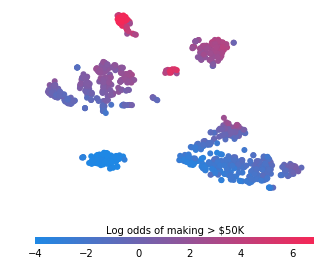

In [94]:
f = plt.figure(figsize=(5,5))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = plt.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()

# Conclusões:

A partir dos resultados obtidos, conclui-se que para o dataset "Adult Census Income", a grande maioria das features mapeadas são importantes para a predição binária proposta, condizente com a expectativa social do fenômeno. Em particular, analisando as features de raça e gênero, é evidente que o modelo as enxergou como determinantes para tomar a classificação final dos indivíduos, pois mazelas sociais levam indivíduos do gênero feminino e pessoas de etnias afrodescendentes a terem uma menor probabilidade de ganharem acima de 50 mil dólares por ano.

Analisando o t-SNE obtido, vemos uma série de pequenos clusters de pessoas para as quais o modelo determinou importância similares de features. É possível identificar um certo gradiente horizontal na probabilidade de se ganhar acima de 50 mil dólares. Intuitivamente podemos entendê-lo como um espectro que atravessa as várias camadas sociais, começando, por exemplo de pessoas negras com baixa escolaridade e gradativamente adicionando fatores que aumentam as chances de um salário elevado como: pessoa branca do gênero masculino tendo ocupação no governo federal.